# Libraries and GPU preparation

In [ ]:
import os
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import numpy as np
import pandas as pd
import librosa
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import wandb
from sklearn.metrics import confusion_matrix
import sklearn
import itertools
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from tensorflow.keras.models import Model

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [ ]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Dataset preparation

In [ ]:
timit_map_str = """
h# 0
d 1
ih 2
dcl 3
jh 4
ux 5
n 6
ow 7
hv 8
iy 9
z 10
ae 11
v 12
axr 13
tcl 14
t 15
ay 16
ng 17
hh 18
m 19
r 20
ey 21
ax 22
kcl 23
k 24
w 25
q 26
ix 27
f 28
s 29
l 30
dh 31
epi 32
eh 33
b 34
ao 35
th 36
er 37
bcl 38
aw 39
y 40
aa 41
ax-h 42
ah 43
nx 44
en 45
ch 46
sh 47
pcl 48
p 49
dx 50
el 51
oy 52
gcl 53
g 54
pau 55
uw 56
zh 57
uh 58
em 59
eng 60
"""
timit_char_map = {}
timit_index_map = {}
for line in timit_map_str.strip().split('\n'):
	ch, index = line.split()
	timit_char_map[ch] = int(index)
	timit_index_map[int(index)] = ch

In [ ]:
TRAIN='./timit_LDC93S1/timit/TIMIT/TRAIN/'
train_phn = []
train_mfcc = []
train_timesteps=[]
for dr1 in os.listdir(TRAIN):
    dr1_path=TRAIN+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"):# and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                if len(mfcc_feat) == len(labels):
                    train_mfcc.append(np.array(mfcc_feat))
                    train_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    train_timesteps.append(np.array(timesteps))

In [ ]:
TEST='./timit_LDC93S1/timit/TIMIT/TEST/'
test_phn = []
test_mfcc = []
test_timesteps=[]
for dr1 in os.listdir(TEST):
    dr1_path=TEST+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"): #and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                if len(mfcc_feat) == len(labels):
                    test_mfcc.append(np.array(mfcc_feat))
                    test_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    test_timesteps.append(np.array(timesteps))

# Basic Model Training

In [ ]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv1D(filters=64,
                    input_shape=(None,13),
                   kernel_size=8,
                   strides=1,
                   activation='relu',
                   padding='same'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(LSTM(1024, return_sequences=True))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
    def train_generator():
        while True:
            i = np.random.randint(0, len(train_phn))
            yield train_mfcc[i][np.newaxis,:,:], train_phn[i][np.newaxis,:]

    model.fit(train_generator(), steps_per_epoch=1000, epochs=500, verbose=1,validation_data=test_generator(),validation_steps=)
    model.summary()

# K-Fold Cross-Valdiation



In [ ]:
def train_valid_generator(set_indexes):
        while True:
            i = np.random.randint(0, len(set_indexes))
            yield train_mfcc[set_indexes[i]][np.newaxis,:,:], train_phn[set_indexes[i]][np.newaxis,:]

In [ ]:
from sklearn.model_selection import KFold
with tf.device('/device:GPU:0'):
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=2000,epochs=20, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=1000,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: {:.4f}".format(moy_train/k))
    print("Testing Accuracy: {:.4f}".format(moy_test/k))

Epoch 1/20
2000/2000 [==============================] - 68s 33ms/step - loss: 2.2278 - accuracy: 0.3818 - val_loss: 1.5432 - val_accuracy: 0.5392
Epoch 2/20
2000/2000 [==============================] - 62s 31ms/step - loss: 1.5217 - accuracy: 0.5391 - val_loss: 1.2854 - val_accuracy: 0.6083
Epoch 3/20
2000/2000 [==============================] - 62s 31ms/step - loss: 1.3068 - accuracy: 0.5948 - val_loss: 1.1920 - val_accuracy: 0.6313
Epoch 4/20
2000/2000 [==============================] - 61s 31ms/step - loss: 1.1937 - accuracy: 0.6272 - val_loss: 1.2029 - val_accuracy: 0.6262
Epoch 5/20
2000/2000 [==============================] - 65s 32ms/step - loss: 1.1430 - accuracy: 0.6387 - val_loss: 1.1273 - val_accuracy: 0.6452
Epoch 6/20
2000/2000 [==============================] - 61s 31ms/step - loss: 1.1098 - accuracy: 0.6469 - val_loss: 1.1827 - val_accuracy: 0.6351
Epoch 7/20
2000/2000 [==============================] - 60s 30ms/step - loss: 1.0651 - accuracy: 0.6613 - val_loss: 1.1202 -

# Phone Classification Results

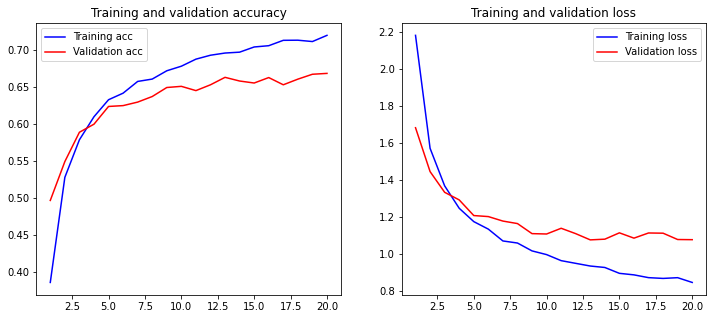

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def test_generator():
    while True:
        i = np.random.randint(0, len(test_mfcc))
        yield test_mfcc[i][np.newaxis,:,:], test_phn[i][np.newaxis,:]

In [ ]:
model.save("Conv1D_LSTM_1024_20epochs_3drop.h5")

In [ ]:
model = tf.keras.models.load_model('./Conv1D_LSTM_1024_20epochs_3drop.h5')

In [ ]:
model.evaluate(test_generator(),steps=len(test_mfcc))

1473/1473 [==============================] - 19s 13ms/step - loss: 1.1467 - accuracy: 0.6520


[1.14670991897583, 0.6519597768783569]

In [ ]:
pred_labels = []
true_labels = []

for i in range(0,len(test_mfcc)):
    pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
    pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
    true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

In [ ]:
flat_pred = [item for sublist in pred_labels for item in sublist]
flat_true = [item for sublist in true_labels for item in sublist]

In [ ]:
accuracy_score(flat_true, flat_pred)

0.6499066391187617

In [ ]:
cnf = sklearn.metrics.confusion_matrix(flat_true, flat_pred)

In [ ]:
def plot_big_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(40,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title,fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=20)
    plt.yticks(tick_marks, classes,fontsize=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()
    plt.savefig('confusion_matrix_phn.png')

Normalized confusion matrix
[[4.73442207e-01 3.33756144e-02 5.74758205e-02 ... 1.03060092e-03
  3.17107975e-04 7.92769938e-05]
 [4.61361015e-03 7.29609491e-01 1.02158510e-02 ... 2.19695721e-04
  4.39391443e-04 5.49239304e-05]
 [4.08192911e-02 5.31667635e-02 3.38611273e-01 ... 4.35793144e-04
  1.74317257e-03 0.00000000e+00]
 ...
 [7.68639508e-04 7.68639508e-04 5.12426339e-04 ... 6.15680246e-01
  1.02485268e-03 7.68639508e-04]
 [3.20034137e-04 3.20034137e-04 3.20034137e-04 ... 0.00000000e+00
  6.19692767e-01 6.08064860e-03]
 [3.64298725e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.42076503e-01 2.82331512e-01]]


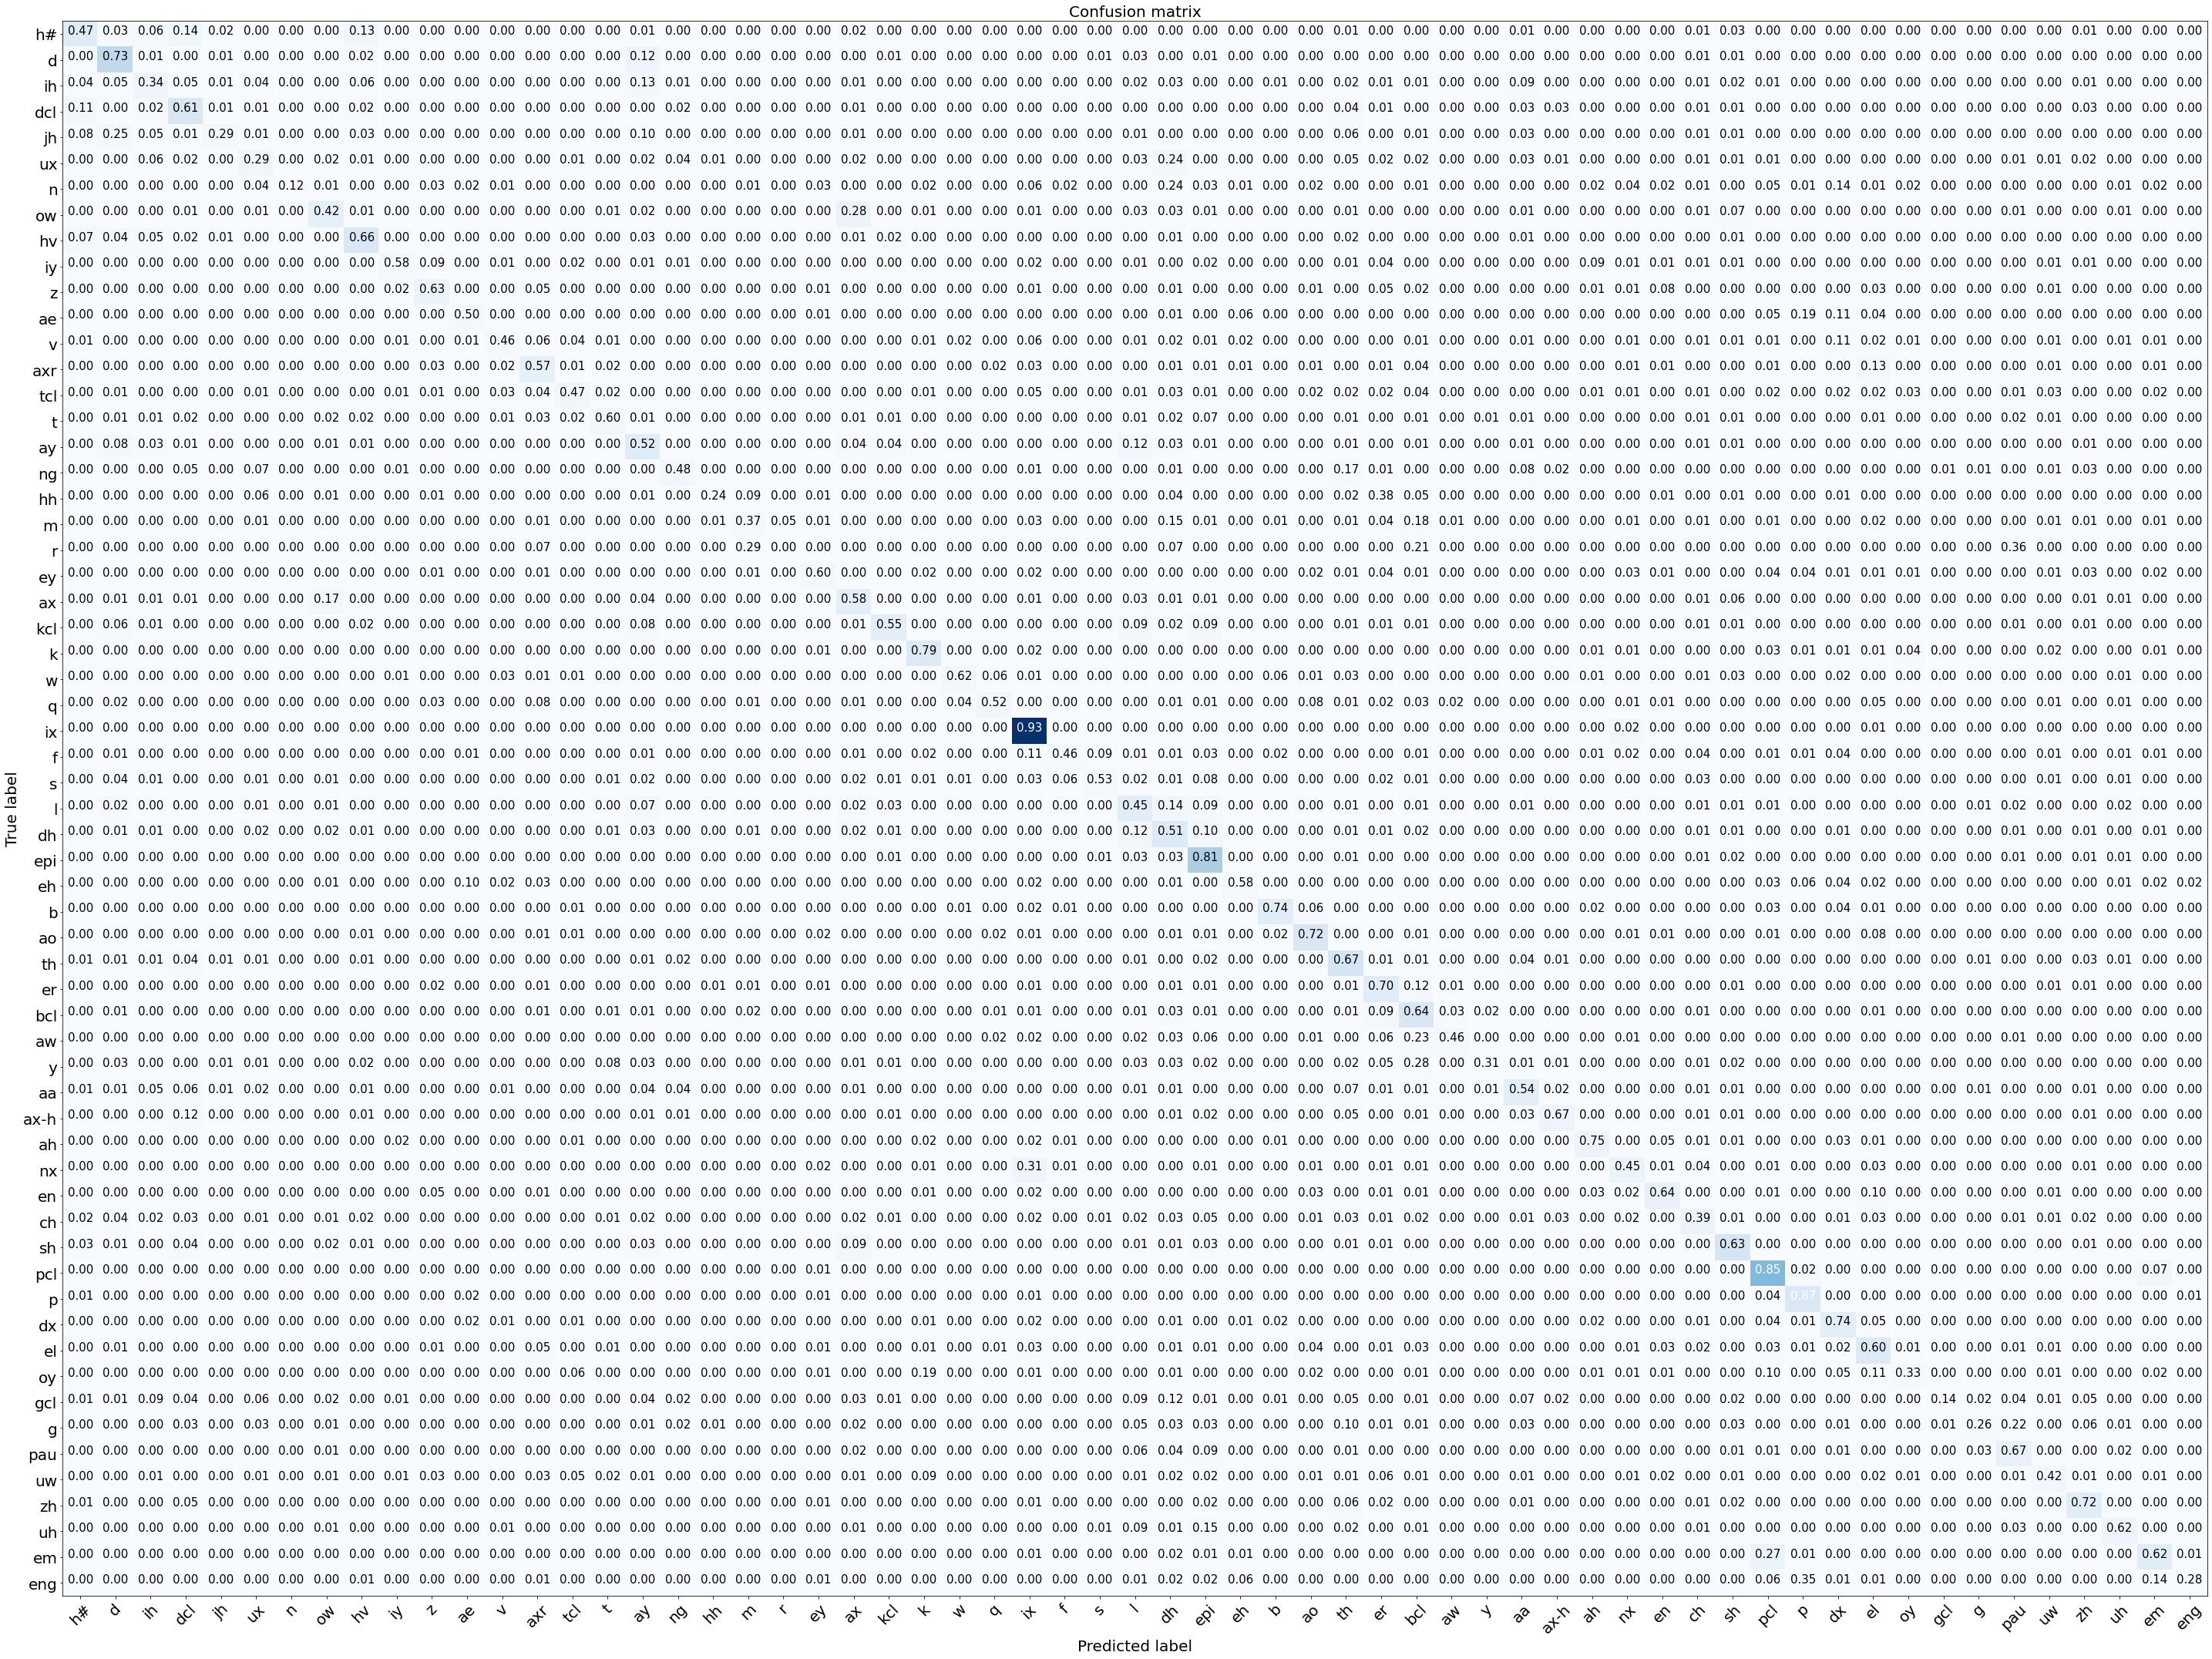

In [ ]:
plot_big_confusion_matrix(cnf,timit_char_map.keys(),normalize=True)

In [ ]:
timit_char_map.keys()

dict_keys(['h#', 'd', 'ih', 'dcl', 'jh', 'ux', 'n', 'ow', 'hv', 'iy', 'z', 'ae', 'v', 'axr', 'tcl', 't', 'ay', 'ng', 'hh', 'm', 'r', 'ey', 'ax', 'kcl', 'k', 'w', 'q', 'ix', 'f', 's', 'l', 'dh', 'epi', 'eh', 'b', 'ao', 'th', 'er', 'bcl', 'aw', 'y', 'aa', 'ax-h', 'ah', 'nx', 'en', 'ch', 'sh', 'pcl', 'p', 'dx', 'el', 'oy', 'gcl', 'g', 'pau', 'uw', 'zh', 'uh', 'em', 'eng'])

# Visime Classification Results

In [ ]:
visime_map_str = """
h# 1
d 5
ih 3
dcl 1 
jh 7
ux 3
n 6
ow 9 
hv 7
iy 3
z 5
ae 8 
v 4
axr 3
tcl 1 
t 5
ay 10 
ng 6
hh 6
m 2 
r 7
ey 8 
ax 3
kcl 1 
k 6
w 4
q 1 
ix 3
f 4
s 7
l 6
dh 5
epi 1 
eh 8 
b 2 
ao 9 
th 5
er 7
bcl 1 
aw 9 
y 3
aa 9
ax-h 3
ah 10
nx 6
en 6
ch 7
sh 7
pcl 1 
p 2
dx 6
el 6
oy 9
gcl 1 
g 6
pau 1 
uw 5
zh 7
uh 5
em 2
eng 6
"""
visime_char_map = {}
visime_index_map = {}
for line in visime_map_str.strip().split('\n'):
	ch, index = line.split()
	visime_char_map[ch] = int(index)
	visime_index_map[int(index)] = ch

In [ ]:
flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
flat_vis_true = [visime_char_map[ph] for ph in flat_true]

In [ ]:
labels = sorted(list(visime_index_map.keys()))

In [ ]:
cnf_vis = sklearn.metrics.confusion_matrix(flat_vis_true, flat_vis_pred)

In [ ]:
cnf_vis

array([[99063,  1529,  2582,  1238,  1424,  3210,  1862,   925,   850,
          486],
       [ 1060,  9859,   392,   232,   286,  1341,   176,    84,    62,
           59],
       [ 1327,   650, 55030,   688,  1233,  2435,  5704,  2703,   899,
          719],
       [ 1150,   541,   702, 14194,   828,   809,   640,   106,   657,
           87],
       [ 2188,   386,  1961,   836, 16145,  1029,  3833,   204,   362,
          169],
       [ 2758,  1954,  2804,   829,  1025, 32422,  1060,   744,  2144,
          435],
       [ 1453,   386,  3727,   515,  2633,   733, 51236,  1336,  1303,
          355],
       [  479,   215,  4702,   204,   234,   597,  1253, 29344,   538,
         1185],
       [  527,   303,   885,   733,   349,  2796,  1323,  2371, 27930,
         3828],
       [  196,   176,   767,   184,   140,   621,   517,  2225,  2541,
        10595]])

In [ ]:
def plot_small_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(40,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title,fontsize=40)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=40)
    plt.yticks(tick_marks, classes,fontsize=40)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 fontsize=30,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
    plt.tight_layout()
    plt.savefig('confusion_matrix_phn.png')

Normalized confusion matrix
[[0.87535456 0.01351077 0.02281544 0.01093939 0.01258295 0.02836466
  0.01645327 0.00817362 0.00751089 0.00429446]
 [0.07822301 0.72754778 0.02892775 0.01712051 0.02110545 0.09895949
  0.01298797 0.0061988  0.00457531 0.00435392]
 [0.01858856 0.00910517 0.77085785 0.00963747 0.01727181 0.03410937
  0.07990138 0.03786351 0.01259315 0.01007172]
 [0.05833418 0.02744243 0.03560921 0.71999594 0.04200061 0.04103683
  0.03246424 0.00537689 0.03332657 0.00441311]
 [0.0806993  0.01423671 0.07232693 0.03083392 0.59547081 0.03795227
  0.1413713  0.00752407 0.01335153 0.00623317]
 [0.05972929 0.04231727 0.0607255  0.01795344 0.02219816 0.70215485
  0.02295615 0.01611262 0.04643205 0.00942068]
 [0.02281829 0.00606184 0.05852977 0.00808769 0.04134931 0.01151122
  0.80462333 0.02098089 0.02046265 0.00557501]
 [0.01236097 0.00554824 0.1213388  0.00526438 0.00603855 0.01540605
  0.03233465 0.75724497 0.01388351 0.03057986]
 [0.01283957 0.00738214 0.0215617  0.01785845 0.0085

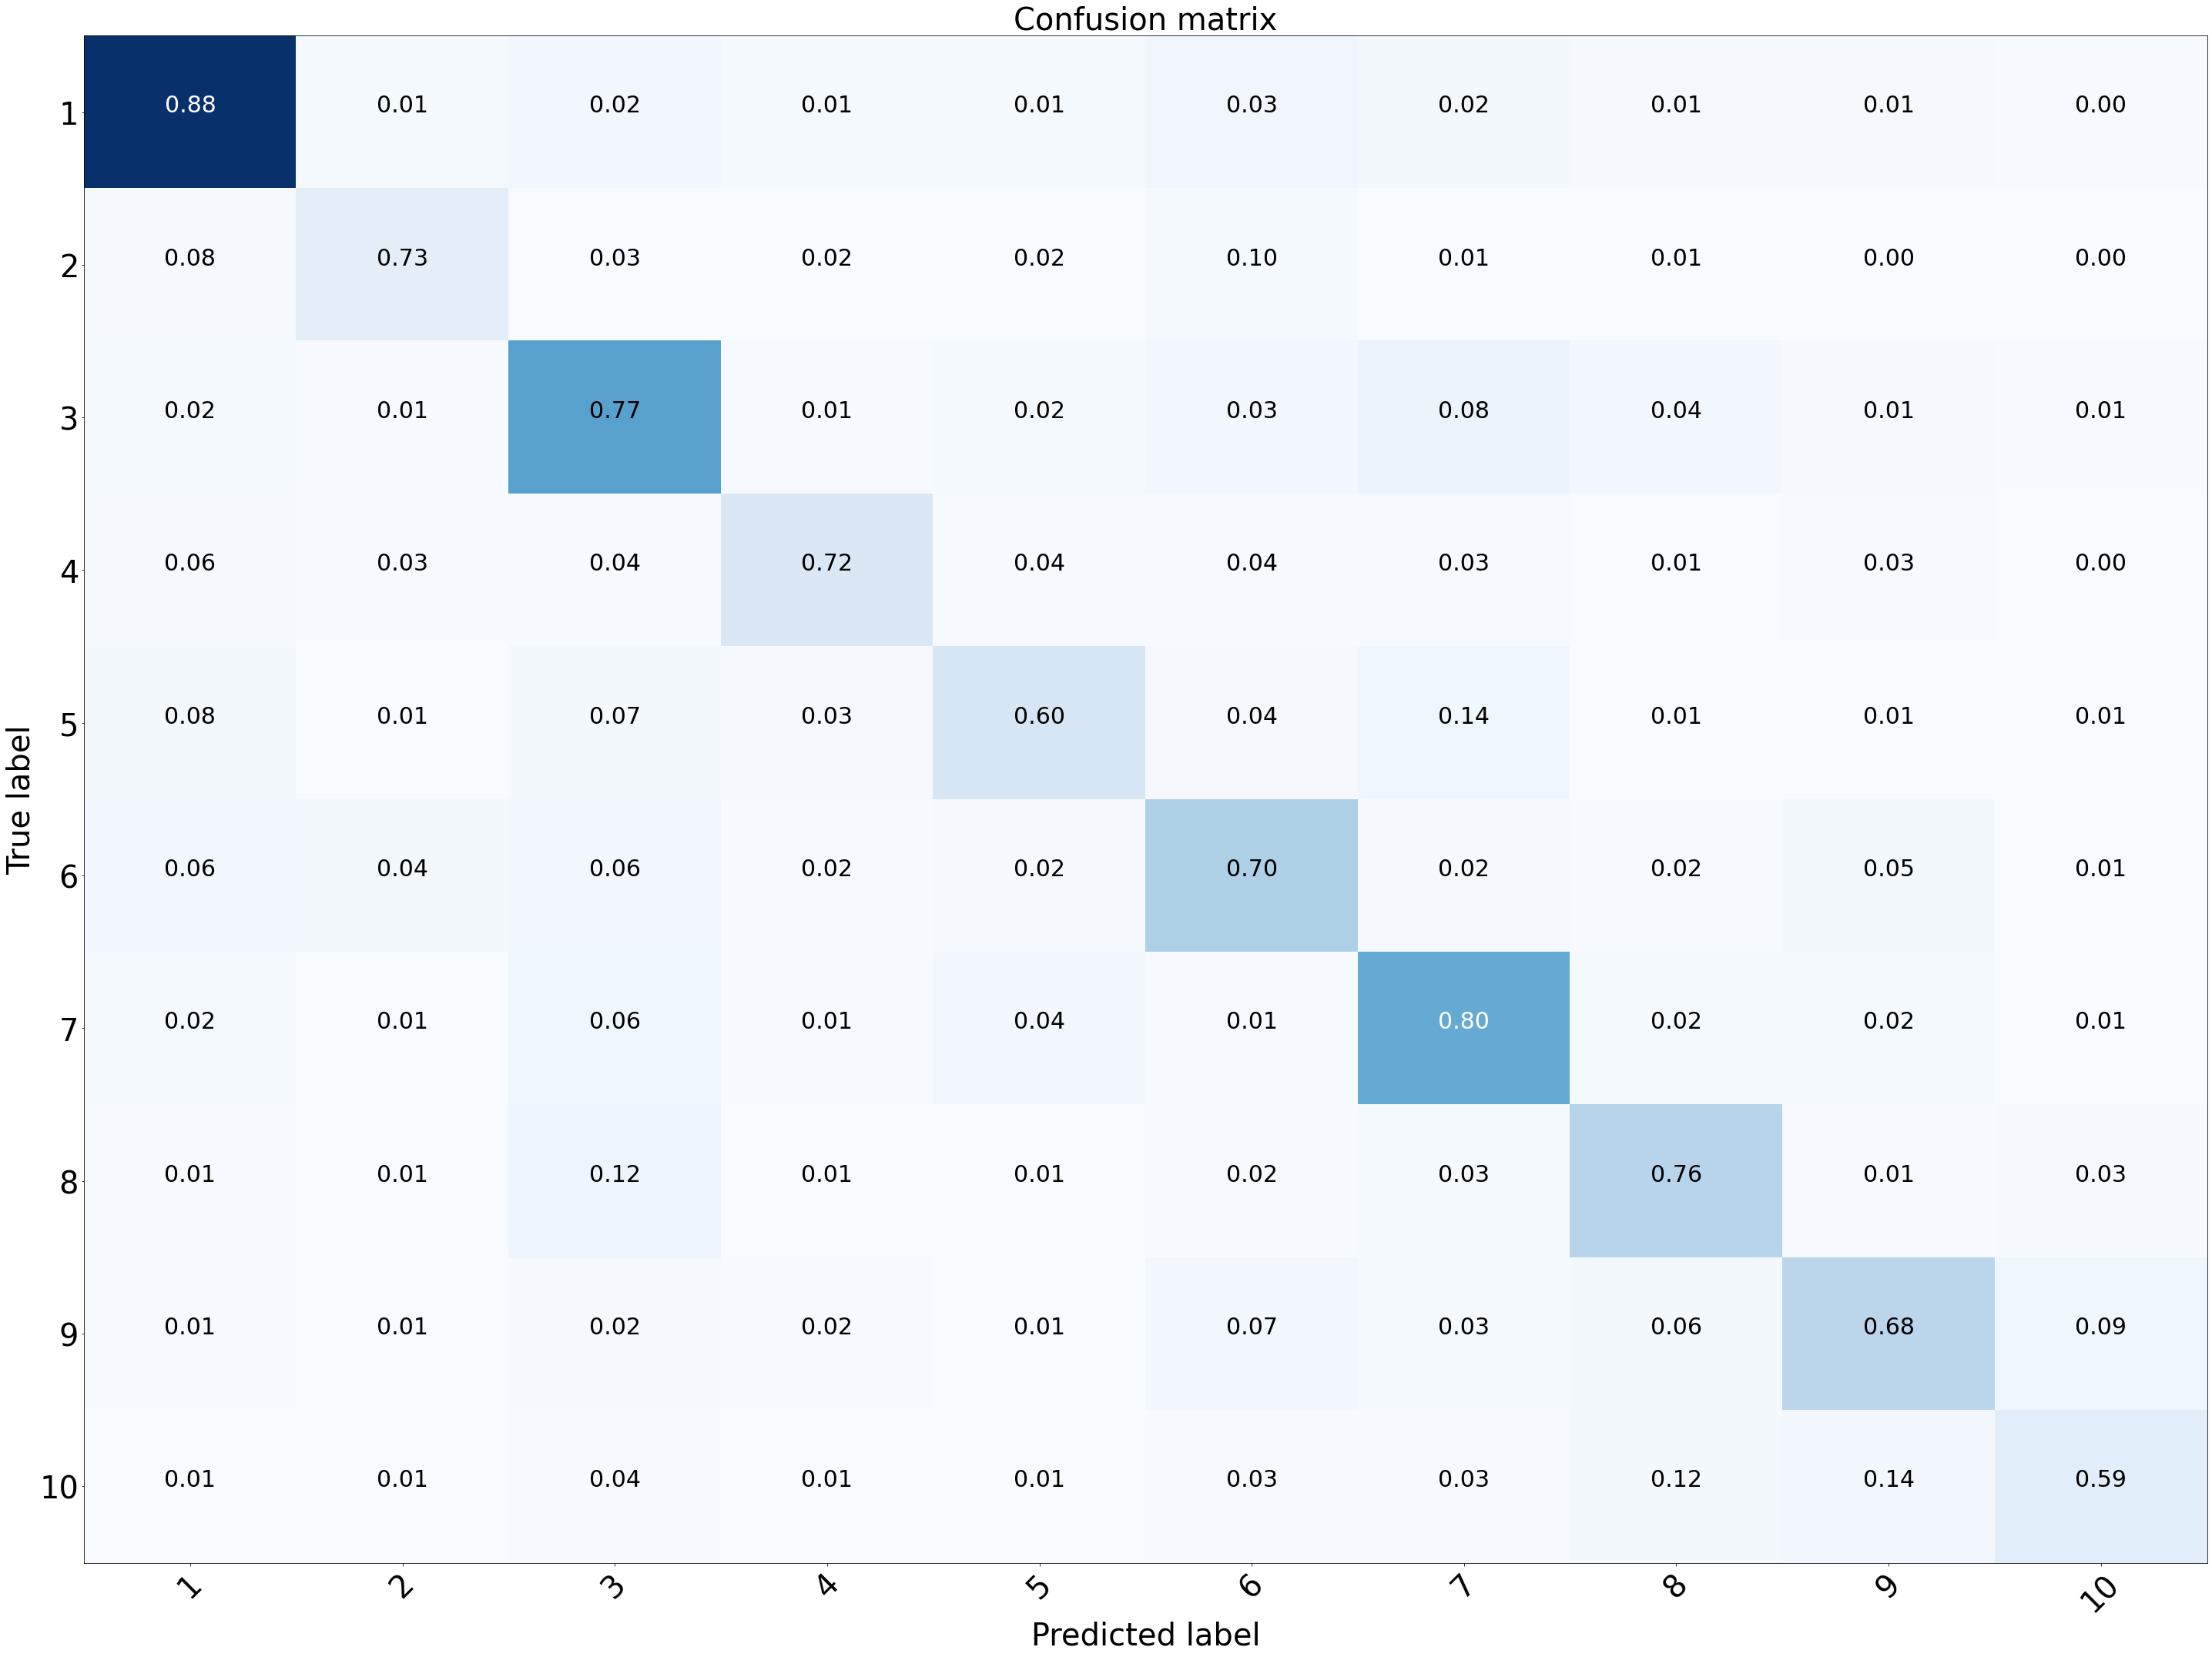

In [ ]:
plot_small_confusion_matrix(cnf_vis,labels,normalize=True)

In [ ]:
accuracy_score(flat_vis_true, flat_vis_pred)

0.7641626799544796

In [ ]:
print(sklearn.metrics.confusion_matrix(flat_vis_true, flat_vis_pred, labels=labels))

[[99063  1529  2582  1238  1424  3210  1862   925   850   486]
 [ 1060  9859   392   232   286  1341   176    84    62    59]
 [ 1327   650 55030   688  1233  2435  5704  2703   899   719]
 [ 1150   541   702 14194   828   809   640   106   657    87]
 [ 2188   386  1961   836 16145  1029  3833   204   362   169]
 [ 2758  1954  2804   829  1025 32422  1060   744  2144   435]
 [ 1453   386  3727   515  2633   733 51236  1336  1303   355]
 [  479   215  4702   204   234   597  1253 29344   538  1185]
 [  527   303   885   733   349  2796  1323  2371 27930  3828]
 [  196   176   767   184   140   621   517  2225  2541 10595]]


In [ ]:
print(sklearn.metrics.classification_report(flat_vis_true, flat_vis_pred, labels=labels))

              precision    recall  f1-score   support

           1       0.90      0.88      0.89    113169
           2       0.62      0.73      0.67     13551
           3       0.75      0.77      0.76     71388
           4       0.72      0.72      0.72     19714
           5       0.66      0.60      0.63     27113
           6       0.70      0.70      0.70     46175
           7       0.76      0.80      0.78     63677
           8       0.73      0.76      0.74     38751
           9       0.75      0.68      0.71     41045
          10       0.59      0.59      0.59     17962

    accuracy                           0.76    452545
   macro avg       0.72      0.72      0.72    452545
weighted avg       0.77      0.76      0.76    452545

